In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import XYZfromAET, AETfromXYZ

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

np.random.seed(114514)
xp.random.seed(114514)

has cupy


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has BBHx waveform


## Load the data generated in example 1

In [2]:
with open("FDSimulationData.pkl", "rb") as datafile:
    datadict = pickle.load(datafile)
datadict.keys()

dict_keys(['frequency', 'AET', 'parameters', 'response_kwargs'])

In [3]:
data_frequency = xp.array(datadict["frequency"])
delta_f = data_frequency[1] - data_frequency[0]
Tobs = 1. / delta_f

data_channels = xp.array(datadict["AET"])

fiducial_parameters = datadict["parameters"]

response_kwargs = datadict["response_kwargs"]
response_kwargs["interpolation"] = False 

data_frequency.shape, data_channels.shape, response_kwargs, fiducial_parameters

((20715,),
 (3, 20715),
 {'modes': [(2, 2)],
  'tmin': 60.0,
  'tmax': 65.0,
  'TDIGeneration': '2nd',
  'optimal_combination': True,
  'output_by_mode': False,
  'interpolation': False},
 {'chirp_mass': 1000000.0,
  'mass_ratio': 0.4719138674211496,
  'spin_1z': -0.219017,
  'spin_2z': 0.777287,
  'coalescence_time': 64.0,
  'coalescence_phase': 3.123620213369193,
  'luminosity_distance': 88470.94592236356,
  'inclination': 0.6928647958196155,
  'longitude': 4.484587022801057,
  'latitude': 0.9023185939708002,
  'psi': 2.050979301490759})

## Prepare models 

### orbit

In [4]:
# orbit model 
orbit = Orbit(OrbitDir='../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB')


### waveform and response 
Currently we only have heterodyed likelihood for the (2,2) mode. 
For HM waveforms, heterodyning should be done in a mode-by-mode manner. 

In [5]:
mode = "primary"
use_gpu = True 

# initialize  waveform generator 
WFG = BBHxWaveformGenerator(mode=mode, use_gpu=use_gpu)

# initialize response generator 
FDTDI = BBHxFDTDIResponseGenerator(orbit_class=orbit, waveform_generator=WFG, use_gpu=use_gpu)

channel_names = ["A2", "E2", "T2"]

## Model noise 

In [6]:
# noise PSD model 
PSDfunc = TDIPSDs()

# use the median time to calculate armlengths
arm_time = (response_kwargs["tmin"] + response_kwargs["tmax"]) / 2. * DAY 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit.LTTfunctions()[key](arm_time)
print("arm time (day):", arm_time / DAY)
print("arm lengths:", arms)

PSD_channels = xp.array([
    PSDfunc.PSD_A2_unequal(data_frequency.get(), arms), 
    PSDfunc.PSD_E2_unequal(data_frequency.get(), arms), 
    PSDfunc.PSD_T2_unequal(data_frequency.get(), arms)
])

# covariance matrix 
CovMat = xp.array([
    [PSD_channels[0], xp.zeros_like(PSD_channels[0]), xp.zeros_like(PSD_channels[0])],
    [xp.zeros_like(PSD_channels[0]), PSD_channels[1], xp.zeros_like(PSD_channels[0])],
    [xp.zeros_like(PSD_channels[0]), xp.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = xp.linalg.inv(xp.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)

PSD_channels.shape, InvCovMat.shape 

arm time (day): 62.5
arm lengths: {'12': array(9.9423583), '13': array(9.99401934), '23': array(9.99148366), '21': array(9.94356135), '31': array(9.99487241), '32': array(9.99111644)}


((3, 20715), (20715, 3, 3))

### Verify waveform model with the true parameters 

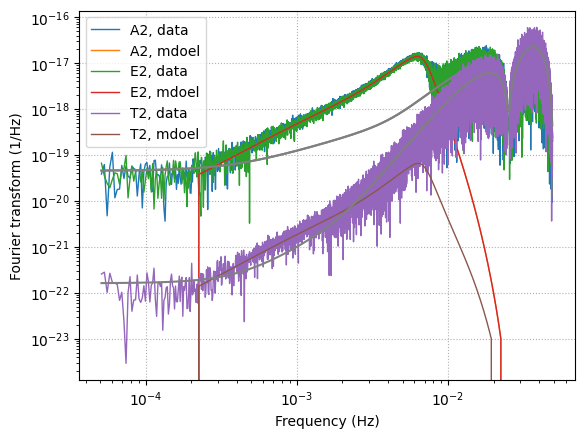

In [7]:
model_channels = FDTDI.Response(
    parameters=fiducial_parameters, 
    freqs=data_frequency, 
    **response_kwargs, 
)

for ich, nch in enumerate(channel_names):
    plt.loglog(data_frequency.get(), np.abs(data_channels[ich].get()), label=nch+', data', linewidth=1)
    plt.loglog(data_frequency.get(), np.abs(model_channels[ich].get()), linewidth=1, label=nch+', mdoel')
    plt.loglog(data_frequency.get(), np.sqrt(PSD_channels[ich] / 2. / delta_f).get(), color="grey")

plt.legend(loc="upper left")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier transform (1/Hz)")
plt.grid(linestyle=":")

## Use A, E channels only 
set $C^{-1}_{T_2 T_2} \equiv 0$ to eliminate the contribution of $T_2$

In [8]:
InvCovMat[:, 2, 2] *= 0. 

## Likelihood

In [10]:
Like = Likelihood(
    response_generator=FDTDI, 
    frequency=data_frequency, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs, 
    use_gpu=use_gpu,
)

number of freuqncies: 20715
min and max frequencies: 5.092592592592592e-05 0.049
response kwargs: {'modes': [(2, 2)], 'tmin': 60.0, 'tmax': 65.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': False}


### prepare heterodyne 

In [11]:
Like.prepare_het_log_like(base_parameters=ParamDict2ParamArr(fiducial_parameters)) # in realistic data analysis, the base parameters are usually not perfect coincident with truths

### test if likelihood peaks at truths 

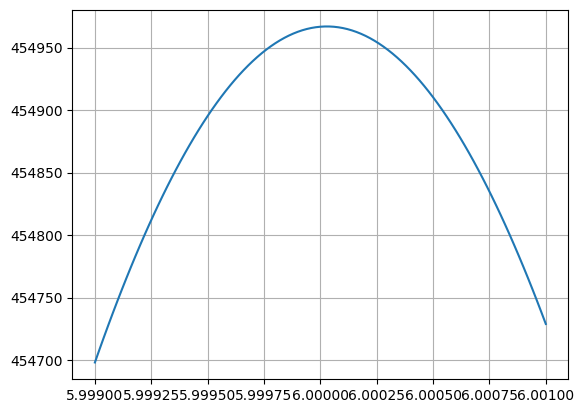

In [12]:
fiducial_param_arr = ParamDict2ParamArr(fiducial_parameters)

N_test=101
test_idx = 0 # Mc
test_params = np.linspace(-1e-3, 1e-3, N_test) + fiducial_param_arr[test_idx]

tmp_params = np.zeros((11, N_test))
for i_test in range(N_test):
    tmp_params[:, i_test] = fiducial_param_arr.copy()
    tmp_params[test_idx][i_test] = test_params[i_test]
# test_lls_vec = Like.full_log_like_vectorized(tmp_params)
test_lls_vec = Like.het_log_like_vectorized(tmp_params)
plt.plot(test_params, test_lls_vec)
plt.grid()

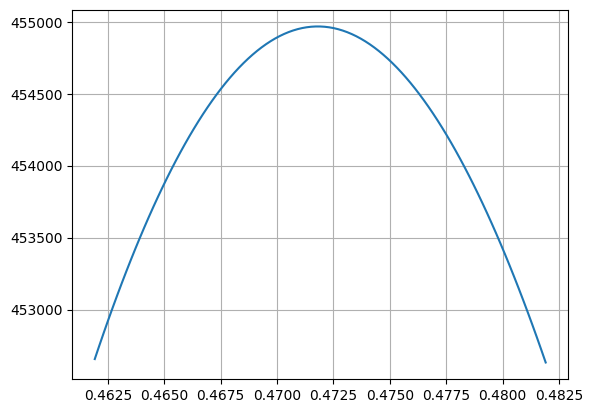

In [13]:
fiducial_param_arr = ParamDict2ParamArr(fiducial_parameters)

N_test=101
test_idx = 1 # q
test_params = np.linspace(-1e-2, 1e-2, N_test) + fiducial_param_arr[test_idx]

tmp_params = np.zeros((11, N_test))
for i_test in range(N_test):
    tmp_params[:, i_test] = fiducial_param_arr.copy()
    tmp_params[test_idx][i_test] = test_params[i_test]
# test_lls_vec = Like.full_log_like_vectorized(tmp_params)
test_lls_vec = Like.het_log_like_vectorized(tmp_params)
plt.plot(test_params, test_lls_vec)
plt.grid()

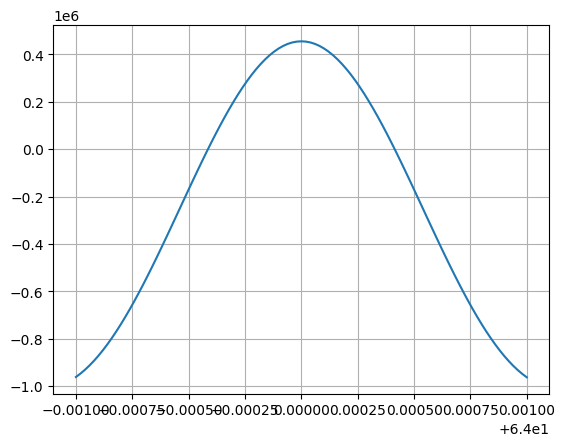

In [14]:
fiducial_param_arr = ParamDict2ParamArr(fiducial_parameters)

N_test=101
test_idx = 4 # tc 
test_params = np.linspace(-1e-3, 1e-3, N_test) + fiducial_param_arr[test_idx]

tmp_params = np.zeros((11, N_test))
for i_test in range(N_test):
    tmp_params[:, i_test] = fiducial_param_arr.copy()
    tmp_params[test_idx][i_test] = test_params[i_test]
# test_lls_vec = Like.full_log_like_vectorized(tmp_params)
test_lls_vec = Like.het_log_like_vectorized(tmp_params)
plt.plot(test_params, test_lls_vec)
plt.grid()

## Run MCMC Sampling 

the aim is to compare the posteriors of full and heterodyned likelihoods, so we choose ideal priors and starting points. 

In [20]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [21]:
labels = [r"${\rm lg}\mathcal{M}_{c,z}$", r"$q$", r"$\chi_{z,1}$", r"$\chi_{z,2}$", r"$t_c$", r"$\varphi_c$", r"${\rm lg} D_L$", r"$\cos \iota$", r"$\lambda$", r"$\sin \beta$", r"$\psi$"]

truths = ParamDict2ParamArr(fiducial_parameters)

truths

[6.0,
 0.4719138674211496,
 -0.219017,
 0.777287,
 64.0,
 3.123620213369193,
 4.946800670728753,
 0.7694193036056729,
 4.484587022801057,
 0.7847660639267573,
 2.050979301490759]

In [ ]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 400 # number of random walkers, more walkers can be used since heterodyned likelihood requires much less vRAM, 400 is a quite large number for this task 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # emcee move 

stop = None 

# set a narrower prior for the instrinsic parameters, since heterodyned likelihood must be based on an initial estimation 
lim_lgMc = [truths[0] - 1e-2, truths[0] + 1e-2]
lim_q = [max(0., truths[1] - 1e-1), min(1., truths[1] + 1e-1)]
lim_chiz1 = [max(-0.99, truths[2] - 5e-1), min(0.99, truths[2] + 5e-1)]
lim_chiz2 = [max(-0.99, truths[3] - 5e-1), min(0.99, truths[3] + 5e-1)]
lim_tc = [truths[4] - 500/DAY, truths[4] + 500/DAY] # assume a preliminary search step to locate the merger within 1000s
lim_phic = [0, TWOPI]
lim_lgD = [3.5, 5.5]
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

# set starting range 
start_lims = np.array(truths)[:, np.newaxis] + np.array([-1e-3, 1e-3])
start_priors_in = {i: uniform_dist(start_lims[i][0], start_lims[i][1]) for i in range(ndim)}
start_priors = ProbDistContainer(start_priors_in)
start_priors.use_cupy = False

lims, start_lims

(array([[ 5.99      ,  6.01      ],
        [ 0.37191387,  0.57191387],
        [-0.719017  ,  0.280983  ],
        [ 0.277287  ,  0.99      ],
        [63.99421296, 64.00578704],
        [ 0.        ,  6.28318531],
        [ 3.5       ,  5.5       ],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]),
 array([[ 5.999     ,  6.001     ],
        [ 0.47091387,  0.47291387],
        [-0.220017  , -0.218017  ],
        [ 0.776287  ,  0.778287  ],
        [63.999     , 64.001     ],
        [ 3.12262021,  3.12462021],
        [ 4.94580067,  4.94780067],
        [ 0.7684193 ,  0.7704193 ],
        [ 4.48358702,  4.48558702],
        [ 0.78376606,  0.78576606],
        [ 2.0499793 ,  2.0519793 ]]))

In [23]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    # return Like.full_log_like_vectorized(np.transpose(params))
    return Like.het_log_like_vectorized(np.transpose(params))

In [24]:
# init_ensemble = EnsembleSampler(
#     nwalkers,
#     ndim,
#     eryn_like, 
#     priors,
#     args=[],
#     tempering_kwargs=tempering_kwargs,
#     stopping_fn=stop,
#     stopping_iterations=10,
#     moves=mcmc_moves,
#     vectorize=True,
# )

# filename='MCMCResults/FullLogLike.h5'
# backend = HDFBackend(filename)
# backend.reset(nwalkers=nwalkers, ndims=ndim, ntemps=ntemps, moves=init_ensemble.backend.move_keys)
# print('args of the backend =', backend.reset_args)
# print('move keys =', backend.move_keys)
# print('Initialization flag of backend =', backend.initialized)


# ensemble = EnsembleSampler(
#     nwalkers,
#     ndim,
#     eryn_like, 
#     priors,
#     args=[],
#     tempering_kwargs=tempering_kwargs,
#     stopping_fn=stop,
#     stopping_iterations=10,
#     moves=init_ensemble.moves,
#     backend=backend,
#     vectorize=True,
# )


ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
)

In [ ]:
# randomize starting positions throughout prior
coords = start_priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)

thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 400, 11)


  4%|▍         | 4101/100000 [08:03<3:03:46,  8.70it/s]

In [ ]:
# # resume run after the run is stopped 
# thin_by =100
# burn = 0
# nsteps = int(100000 / thin_by) # this should be far more than enough 

# out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

## Show moves 

In [ ]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

plt.figure()
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(20): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])
# plt.savefig("MCMC_trajectory_het.jpg")

## Corner plot

In [ ]:
burnin=500
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    # range=lims,
    truths=truths, truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
# plt.savefig("MCMC_corner_het.jpg")
# np.save("chain_het.npy", samp)

## Compare full and heterodyned likelihoods

In [ ]:
sample1 = np.load("chain_full.npy")
sample2 = np.load("chain_het.npy")
num_sample1 = sample1.shape[0]
num_sample2 = sample2.shape[0]
print("shape of original samples:", num_sample1, num_sample2)
num_sample = min([num_sample1, num_sample2]) # use the same number of samples 
sample1 = sample1[:num_sample]
sample2 = sample2[:num_sample]
print("shape of sample:", sample1.shape)

handles = []
figure = corner(
    sample1, bins=50, color=GREEN1, 
    labels=np.array(labels), label_kwargs={'fontsize': 14}, 
    truths=np.array(truths), truth_color=RED, 
    hist_kwargs=dict(density=True),
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2),),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=False, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=False, # whether to fill the corners 
    # contour_kwargs=dict(alpha=0.3),
    );
handles.append(plt.Line2D([], [], color=GREEN1, label="full likelihood", linewidth=2, markersize=20))

figure = corner(
    sample2, bins=50, color=ORANGE, 
    hist_kwargs=dict(density=True),
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2),),
    smooth=0.9,
    plot_density=False, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=False, # whether to fill the corners 
    fig=figure, 
    );
handles.append(plt.Line2D([], [], color=ORANGE, label="heterodyned likelihood", linewidth=2, markersize=20))

figure.legend(
    handles=handles,
    loc="upper right",
    fontsize=25,
    labelcolor="linecolor",
    frameon=False, 
)

# plt.savefig("MCMC_corner_compare.jpg")